# Conglomerate RADAR data of picked bed from radargrams


- Huw put .txt files in /Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_*.txt
- The DELAY column is time. 
- This Converts DELAY to depth.
- saves all data at /Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp

NB Look at the .jcs file to map from the SEQnum (the * in the file name) to other names.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import shutil
from shapely.geometry import Point, LineString, Polygon
import fiona

In [2]:
p = '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp'
os.path.splitext(os.path.basename(p))

('picked_bed', '.shp')

In [3]:
paths = glob.glob('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_*_ICETHK.txt')
paths

['/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_6_ICETHK.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_10_ICETHK.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_26_ICETHK.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_43_ICETHK.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_4_ICETHK.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_41_ICETHK.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_16_ICETHK.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_47_ICETHK.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_8_ICETHK.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_48_ICETHK.txt',
 '/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_30_ICETHK.txt',
 '/Volumes/arc_04/FIELD_

### The Data, ie the picked beds look like:

In [4]:
!head {paths[0]}

CDP SOURCE_X SOURCE_Y DELAY ELEVATION YEAR DAY HOUR MINUTE SECOND 
100 -38931070 -72294780 9230 9764.36 2019 363 1 12 2497 
101 -38930970 -72294600 9230 9763.94 2019 363 1 12 2600 
102 -38930820 -72294330 9230 9763.29 2019 363 1 12 2799 
103 -38930620 -72293980 9230 9762.48 2019 363 1 12 2998 
104 -38930530 -72293810 9230 9762.08 2019 363 1 12 3101 
105 -38930350 -72293460 9230 9761.32 2019 363 1 12 3300 
106 -38930260 -72293270 9230 9760.93 2019 363 1 12 3404 
107 -38930060 -72292890 9230 9760.11 2019 363 1 12 3603 
108 -38929980 -72292720 9230 9759.75 2019 363 1 12 3698 


In [6]:
!head /Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_13_ICETHK.txt

CDP SOURCE_X SOURCE_Y DELAY ELEVATION YEAR DAY HOUR MINUTE SECOND 
100 -37997670 -72935560 8090 5230.75 2019 358 4 25 2104 
101 -37997530 -72935460 8090 5229.17 2019 358 4 25 2199 
102 -37997260 -72935240 8080 5225.98 2019 358 4 25 2398 
103 -37996940 -72934980 8080 5222.36 2019 358 4 25 2597 
104 -37996790 -72934850 8080 5220.64 2019 358 4 25 2700 
105 -37996620 -72934710 8080 5218.71 2019 358 4 25 2804 
106 -37996300 -72934420 8080 5214.95 2019 358 4 25 3003 
107 -37996130 -72934290 8080 5213.08 2019 358 4 25 3098 
108 -37995780 -72933980 8080 5209.01 2019 358 4 25 3296 


## Huws indexing SEQnum is different to arrans, Name. 
## get from one to the other other usind this picked_bed_metadata

In [7]:
 !head /Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/picked_bed_metadata.csv

SEQnum Name           FirstSP  LastSP   NTraces  NTraces2 NPlot    Static   MinOffset MaxOffset Inc    Site   Dir    
 1      line7                            1743     1255     628      1250     0         376126    300           LTOR
 2      line9                            2167     1540     770      1250     0         461583    300           LTOR
 3      line0                            1785     1378     689      1250     0         413181    300           LTOR
 4      line10                           2582     1577     788      1250     0         472866    300           LTOR
 5      line11                           2456     1638     819      1250     0         491087    300           LTOR
 6      line12                           2176     1538     769      1250     0         461119    300           LTOR
 7      line13                           2337     1579     790      1250     0         473550    300           LTOR
 8      line14                           2152     1534     767      12

In [8]:
picked_bed_metadata = pd.read_csv('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/picked_bed_metadata.csv',header=0,delim_whitespace=True,index_col=0)
picked_bed_metadata.head()

,Name,FirstSP,LastSP,NTraces,NTraces2,NPlot,Static,MinOffset,MaxOffset,Inc,Site,Dir
SEQnum,,,,,,,,,,,,
1,line7,1743,1255,628,1250,0,376126,300,LTOR,NaN,NaN,NaN
2,line9,2167,1540,770,1250,0,461583,300,LTOR,NaN,NaN,NaN
3,line0,1785,1378,689,1250,0,413181,300,LTOR,NaN,NaN,NaN
4,line10,2582,1577,788,1250,0,472866,300,LTOR,NaN,NaN,NaN
5,line11,2456,1638,819,1250,0,491087,300,LTOR,NaN,NaN,NaN


In [9]:
picked_bed_metadata.query("Name=='line4'")

,Name,FirstSP,LastSP,NTraces,NTraces2,NPlot,Static,MinOffset,MaxOffset,Inc,Site,Dir
SEQnum,,,,,,,,,,,,
13,line4,2024,1562,781,1250,0,468301,300,LTOR,NaN,NaN,NaN


In [10]:
picked_bed_metadata.iloc[1]['Name']

'line9'

# Make big dataframe of all points

In [11]:
bed_df = pd.DataFrame({},columns=['CDP','SOURCE_X','SOURCE_Y','DELAY','line_name','ELEVATION','YEAR', 'DAY', 'HOUR', 'MINUTE', 'SECOND'])

no_data_SEQnum = []

for SEQnum in tqdm(picked_bed_metadata.index.tolist()):
    
    linename = picked_bed_metadata.loc[SEQnum]['Name']
    
    if linename in ['line0a', 'line0bKIS1']:
        continue
        
    if linename in ['line7', 'line9', 'line0', 'line10', 'line11', 'line12', 'line13',
                    'line14', 'line1', 'line2', 'line3', 'line4', 'line6', 'line7p25',
                    'line7p5', 'line7p75', 'line8', 'lineAPREScross', 'lineAPRESdown', 
                    'lineback2camp', 'linedownchan', 'lineupchan', 'left02', 'left1011',
                    'left1213', 'left1415', 'left35', 'left46', 'left79',
                    'left810', 'right1112', 'right1314', 'right13', 'right24',
                    'right68', 'right910', 'line5']:
        camp = 'KIS2'
    else:
        camp = 'KIS1'
            
    
    try:
        line_df = pd.read_csv(f'/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/radar3View_JCS_{SEQnum}_ICETHK.txt',header=0,sep=' ')
        line_df['line_name'] = picked_bed_metadata.loc[SEQnum]['Name']
        line_df['SEQnum'] = SEQnum
        line_df['camp'] = camp
        bed_df = bed_df.append(line_df,ignore_index=True)
        del line_df
    except:
        
        print(f'SEQnum {SEQnum}, {linename} didnt work')
        no_data_SEQnum.append(SEQnum)

bed_df.rename(columns={'SOURCE_X':'x','SOURCE_Y':'y'},inplace=True)

In [12]:
# need to divide x and y by 10
bed_df.x = bed_df.x.astype('float').copy()
bed_df.y = bed_df.y.astype('float').copy()
bed_df.ELEVATION = bed_df.ELEVATION.astype('float').copy()
bed_df.SECOND = bed_df.SECOND.astype('float').copy()

bed_df.SEQnum = bed_df.SEQnum.astype('int').copy()

In [13]:
bed_df.x = bed_df.x.div(100).copy()
bed_df.y = bed_df.y.div(100).copy()
bed_df.ELEVATION = bed_df.ELEVATION.div(100).copy()
bed_df.SECOND = bed_df.SECOND.div(100).copy()

In [14]:
bed_df['DELAY'] = [int(D) for D in bed_df.DELAY.tolist()]

In [15]:
bed_df.rename(columns={'ELEVATION':'surf'},inplace=True)

In [16]:
bed_df = bed_df.astype({'YEAR': 'str','DAY': 'str','MINUTE': 'str','HOUR': 'str','SECOND':'str'}).copy()

In [17]:
bed_df.dtypes

CDP             object
x              float64
y              float64
DELAY            int64
line_name       object
surf           float64
YEAR            object
DAY             object
HOUR            object
MINUTE          object
SECOND          object
Unnamed: 10    float64
SEQnum           int64
camp            object
dtype: object

In [18]:
#pd.to_datetime(df['year'] * 1000 + df['doy'], format='%Y%j')\n",
datetime = (pd.to_datetime(bed_df.YEAR + bed_df.DAY + bed_df.HOUR+ bed_df.MINUTE, format ='%Y%j%H%M' )+
            pd.Series( [pd.to_timedelta(f'{t} seconds') for t in bed_df.SECOND.tolist()] )
           )
   

In [19]:
#pd.to_datetime(df['year'] * 1000 + df['doy'], format='%Y%j')
datetime = pd.to_datetime(bed_df.YEAR + bed_df.DAY + bed_df.HOUR+ bed_df.MINUTE, format ='%Y%j%H%M' ) + pd.Series( [pd.to_timedelta(f'{t} seconds') for t in bed_df.SECOND.tolist()] )

In [20]:
iso_func = lambda t : t.isoformat()

bed_df['time_UTC'] = datetime.apply(iso_func)

In [21]:
bed_df.head()

,CDP,x,y,DELAY,line_name,surf,YEAR,DAY,HOUR,MINUTE,SECOND,Unnamed: 10,SEQnum,camp,time_UTC
0,100,-382160.3,-726598.7,8780,line7,71.2867,2019,361,21,52,1.0,NaN,1,KIS2,2019-12-27T21:52:01
1,101,-382158.5,-726597.0,8780,line7,71.2825,2019,361,21,52,2.98,NaN,1,KIS2,2019-12-27T21:52:02.980000
2,102,-382155.7,-726594.2,8780,line7,71.2759,2019,361,21,52,4.97,NaN,1,KIS2,2019-12-27T21:52:04.970000
3,103,-382154.0,-726592.4,8780,line7,71.2717,2019,361,21,52,6.01,NaN,1,KIS2,2019-12-27T21:52:06.010000
4,104,-382152.3,-726590.8,8780,line7,71.2678,2019,361,21,52,7.04,NaN,1,KIS2,2019-12-27T21:52:07.040000


In [22]:
bed_df.drop(columns=['YEAR','DAY','HOUR','MINUTE','SECOND'],inplace=True)

In [23]:
points = [Point(xy) for xy in zip(bed_df.x,bed_df.y)]
bed_gdf = gpd.GeoDataFrame(bed_df,geometry=points,crs="EPSG:3031")

## all lines are visible

<AxesSubplot:>

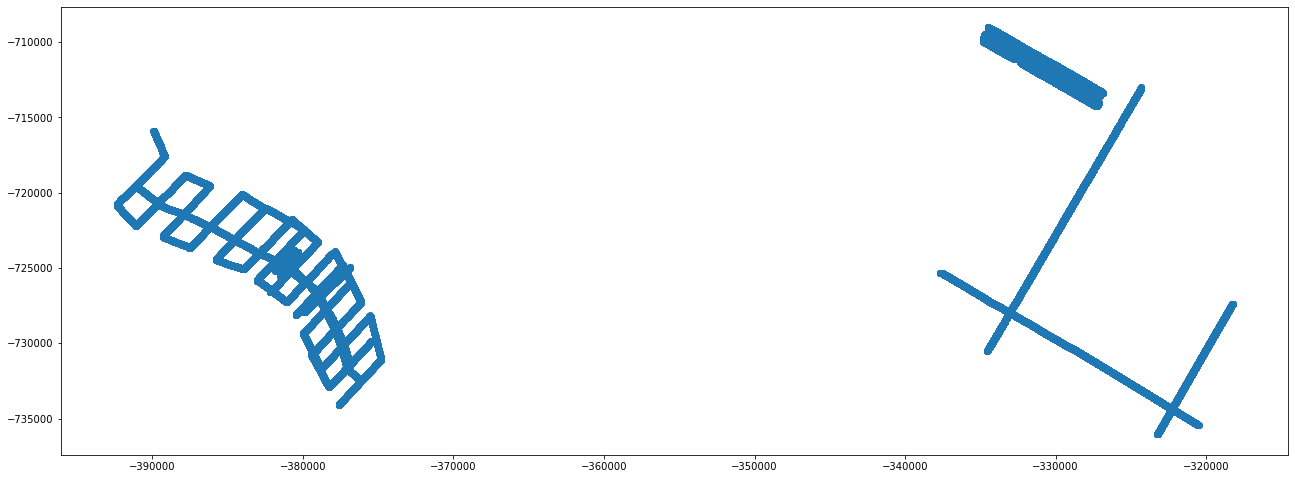

In [24]:
bed_gdf.plot(figsize=(22,14))

<AxesSubplot:>

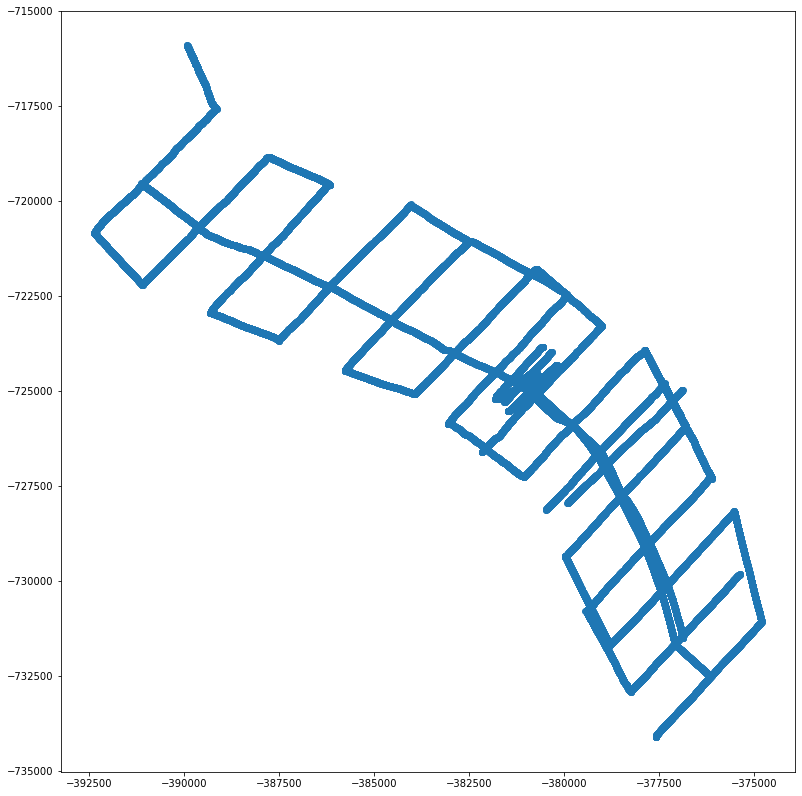

In [25]:
bed_gdf[bed_gdf.camp=='KIS2'].plot(figsize=(22,14))

<AxesSubplot:>

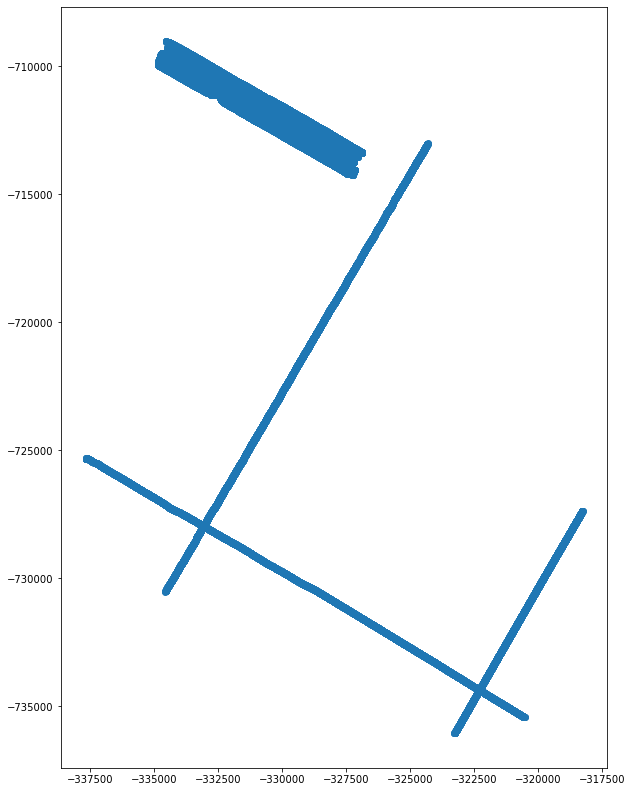

In [26]:
bed_gdf[bed_gdf.camp=='KIS1'].plot(figsize=(22,14))

In [27]:
bed_gdf.query("line_name=='line4'")

,CDP,x,y,DELAY,line_name,surf,Unnamed: 10,SEQnum,camp,time_UTC,geometry
19806,100,-379976.7,-729355.6,8090,line4,52.3075,NaN,13,KIS2,2019-12-24T04:25:21.040000,POINT (-379976.700 -729355.600)
19807,101,-379975.3,-729354.6,8090,line4,52.2917,NaN,13,KIS2,2019-12-24T04:25:21.990000,POINT (-379975.300 -729354.600)
19808,102,-379972.6,-729352.4,8080,line4,52.2598,NaN,13,KIS2,2019-12-24T04:25:23.980000,POINT (-379972.600 -729352.400)
19809,103,-379969.4,-729349.8,8080,line4,52.2236,NaN,13,KIS2,2019-12-24T04:25:25.970000,POINT (-379969.400 -729349.800)
19810,104,-379967.9,-729348.5,8080,line4,52.2064,NaN,13,KIS2,2019-12-24T04:25:27,POINT (-379967.900 -729348.500)
...,...,...,...,...,...,...,...,...,...,...,...
21363,1657,-376806.8,-725929.8,8180,line4,47.1320,NaN,13,KIS2,2019-12-24T04:58:55.980000,POINT (-376806.800 -725929.800)
21364,1658,-376805.2,-725927.9,8180,line4,47.1249,NaN,13,KIS2,2019-12-24T04:58:57.010000,POINT (-376805.200 -725927.900)
21365,1659,-376802.5,-725924.8,8190,line4,47.1123,NaN,13,KIS2,2019-12-24T04:58:59,POINT (-376802.500 -725924.800)
21366,1660,-376801.2,-725923.2,8190,line4,47.1056,NaN,13,KIS2,2019-12-24T04:59:00.040000,POINT (-376801.200 -725923.200)


In [28]:
bed_gdf.to_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')

In [29]:
int(55.5)

55

# Convert DELAY to depth

follow "Investigations of the form and flow of ice sheets and glaciers using radio-echo sounding"
https://iopscience.iop.org/article/10.1088/0034-4885/67/10/R03/pdf

168 nm/s ice velocity

"+" 7 m firn correction

DELAY is two way travel time

$u  = d / t$


$ t_{firm} = thickness_{firn} velocity_{firn} $

$separationdistance^2 + depth^2 = (traveldistance/2)^2$

$depth = \sqrt{(traveldistance/2)^2 -  separationdistance^2  }$

$traveldistance = DELAY  velocity$

$depth = \sqrt{( DELAY  velocity/2)^2 -  separationdistance^2  }$


In [30]:
velocity_ice = 168e-3
velocity_firn = 400
firn_correction = 7
separation_distance = 58.37

In [31]:
bed_gdf['ice_thickn'] = np.sqrt( (bed_gdf.DELAY.copy()*velocity_ice/2)**2 - (separation_distance/2)**2  ) + 7 


In [32]:
# np.sqrt( (5370*velocity_ice/2)**2 - (separation_distance/2)**2  ) + 7 

In [33]:
bed_df.drop(columns=['DELAY'],inplace=True)

In [34]:
bed_gdf['bed'] = bed_gdf.surf - bed_gdf.ice_thickn

In [35]:
bed_gdf.to_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')

In [36]:
bed_gdf.keys()

Index(['CDP', 'x', 'y', 'DELAY', 'line_name', 'surf', 'Unnamed: 10', 'SEQnum',
       'camp', 'time_UTC', 'geometry', 'ice_thickn', 'bed'],
      dtype='object')

In [37]:
bed_gdf.head()

,CDP,x,y,DELAY,line_name,surf,Unnamed: 10,SEQnum,camp,time_UTC,geometry,ice_thickn,bed
0,100,-382160.3,-726598.7,8780,line7,71.2867,NaN,1,KIS2,2019-12-27T21:52:01,POINT (-382160.300 -726598.700),743.942322,-672.655622
1,101,-382158.5,-726597.0,8780,line7,71.2825,NaN,1,KIS2,2019-12-27T21:52:02.980000,POINT (-382158.500 -726597.000),743.942322,-672.659822
2,102,-382155.7,-726594.2,8780,line7,71.2759,NaN,1,KIS2,2019-12-27T21:52:04.970000,POINT (-382155.700 -726594.200),743.942322,-672.666422
3,103,-382154.0,-726592.4,8780,line7,71.2717,NaN,1,KIS2,2019-12-27T21:52:06.010000,POINT (-382154.000 -726592.400),743.942322,-672.670622
4,104,-382152.3,-726590.8,8780,line7,71.2678,NaN,1,KIS2,2019-12-27T21:52:07.040000,POINT (-382152.300 -726590.800),743.942322,-672.674522


In [38]:
bed_gdf.dtypes

CDP              object
x               float64
y               float64
DELAY             int64
line_name        object
surf            float64
Unnamed: 10     float64
SEQnum            int64
camp             object
time_UTC         object
geometry       geometry
ice_thickn      float64
bed             float64
dtype: object

In [39]:
1+1

2